In [2]:
from __init__ import *
from Utils import *
from Datahandler import DataLoader
from multiprocessing import Pool
from sklearn.preprocessing import QuantileTransformer
import torch
from collections import Counter
from sklearn.cluster import KMeans
import joblib

In [3]:
DATE = '2022-07-08'
DIR_PATH = 'Z:\Stock\L1_tick\JQ' 
SYMBOL = '688819_XSHG'

In [3]:
df = DataLoader(DATE, SYMBOL, DIR_PATH) # most of time cost due to data expansion (~100 s)
df = df.get_df()

[Load Data]  0.299 seconds
[Data Expansion]  0.084 seconds
[Features Computation 0]  0.009 seconds


In [4]:
FEATURES = ['F1_1', 'F1_2', 'F1_3', 'F1_4',                                                 
                                                                                            
            'F2_1', 'F2_2', 'F2_3', 'F2_4', 'F2_5', 'F2_6', 'F2_7',             
                                                                                        
            'F3_1', 'F3_2',                                              
                                                                                            
            'F4_1',                                                        
                                                                                            
            'F5_1',                
                                                                                            
            'F6_1', 'F6_2',
            'F7_1', 'F7_2',]

CLUSTER_NUM = 8
ALL_ENTRIES = FEATURES + ['WAP1', 'WAP2', 'r1', 'r2', 'target_r', 'target_vol']

In [43]:
conditions = pd.Series([True, True, False])
con = pd.Series([False ,False, False])

In [49]:
class DataSet(object):
    
    def __init__(self, Stock_Info, dir_path, Daily_Start = ' 09:30:00', Daily_End = ' 14:59:59'):
        """
        Stock_Info: List(Tuple(str, List)) => [(trading date, [stock ids]), ...]
        """
        self.stock_info = Stock_Info
        self._dir_path = dir_path
        self.daily_start = Daily_Start
        self.daily_end = Daily_End
        self.sample_frac = 0.8
        self.WIN1 = 60
        self.WIN2 = 600


    # @timer('Load Data==')
    def load_data(self, date, symbol):

        loader = DataLoader(date, symbol, self._dir_path) 
        _df_ = loader.get_df()
        _df_ = _df_[date + self.daily_start: date + self.daily_end]

        with timer('Rolling...'):
            _df_['WAP1_ROLLING_WIN2'] = list(_df_['WAP1'].rolling(self.WIN2))
            _df_['r1_ROLLING_WIN1']   = list(_df_['r1'].rolling(self.WIN1))
            _df_['r1_ROLLING_WIN2']   = list(_df_['r1'].rolling(self.WIN2))
            _df_['r2_ROLLING_WIN1']   = list(_df_['r2'].rolling(self.WIN1))
            _df_['r2_ROLLING_WIN2']   = list(_df_['r2'].rolling(self.WIN2))

        _df_['target_r']   = _df_['r1'].rolling(self.WIN2).sum().shift(-self.WIN2)
        _df_['target_vol'] = _df_['WAP1'].rolling(self.WIN2).std().shift(-self.WIN2)
        
        return _df_


    @timer('Features Computation 1: price impact')
    def get_price_impact(self, _df_):

        Ask_Price = (_df_['a1_p']*_df_['a1_v'] + _df_['a2_p']*_df_['a2_v']) / (_df_['a1_v'] + _df_['a2_v'])
        Bid_Price = (_df_['b1_p']*_df_['b1_v'] + _df_['b2_p']*_df_['b2_v']) / (_df_['b1_v'] + _df_['b2_v'])

        _df_['F1_1']  = (_df_['a1_p'] - Ask_Price) / _df_['a1_p']
        _df_['F1_2']  = (_df_['a2_p'] - Ask_Price) / _df_['a2_p']

        _df_['F1_3']  = (_df_['b1_p'] - Bid_Price) / _df_['b1_p']
        _df_['F1_4']  = (_df_['b2_p'] - Bid_Price) / _df_['b2_p']

        return _df_


    @timer('Features Computation 2: spread & imbalance')
    def get_spread(self, _df_):

        _df_['F2_1']  = _df_['b1_v'] - _df_['b2_v']
        _df_['F2_2']  = _df_['a1_v'] - _df_['a2_v']

        _df_['F2_3']  = (_df_['a1_p'] - _df_['b1_p'])/_df_['WAP1']
        _df_['F2_4']  = _df_['a1_v'] - _df_['b1_v']

        _df_['F2_5']  = (_df_['a2_p'] - _df_['b2_p'])/_df_['WAP2']
        _df_['F2_6']  = _df_['a2_v'] - _df_['b2_v']

        _df_['F2_7']  = np.log((_df_['a1_v']+_df_['a2_v']) / (_df_['b1_v']+_df_['b2_v']))

        return _df_


    @timer('Features Computation 3: depth')
    def get_depth(self, _df_):

        _df_['F3_1']  = _df_['a1_v'] + _df_['a2_v']
        _df_['F3_2']  = _df_['b1_v'] + _df_['b2_v']

        return _df_


    @timer('Features Computation 4: higher order moment')
    def get_high_order_moment(self, _df_):

        def cal_WAP_skew(slice, win_size):
            return (np.power((slice - slice.mean())/slice.std(), 3).sum()) / win_size

        _df_['F4_1']  = _df_['WAP1_ROLLING_WIN2'].apply(lambda x: cal_WAP_skew(x, self.WIN2))

        return _df_


    @timer('Features Computation 5: trend')
    def get_trend(self, _df_):
        
        _df_['F5_1'] = _df_['WAP1'].ewm(span=self.WIN1, adjust=False).mean() - _df_['WAP1'].ewm(span=self.WIN2, adjust=False).mean()
        return _df_


    @timer('Features Computation 6: momentum')
    def get_momentum(self, _df_):

        def cal_tsmom(slice, win_size):
            return max(np.cumsum(slice), key=abs) / win_size

        _df_['F6_1'] = _df_['r1_ROLLING_WIN1'].apply(lambda x: cal_tsmom(x, self.WIN1))
        _df_['F6_2'] = _df_['r1_ROLLING_WIN2'].apply(lambda x: cal_tsmom(x, self.WIN2))

        return _df_


    @timer('Features Computation 7: volatility')
    def get_volatility(self, _df_):

        def cal_vol(slice):
            return np.sqrt(np.power(slice, 2).sum())

        _df_['F7_1'] = _df_['r1_ROLLING_WIN1'].apply(lambda x: cal_vol(x))
        _df_['F7_2'] = _df_['r1_ROLLING_WIN2'].apply(lambda x: cal_vol(x))

        return _df_


    def sample(self, _df_, _frac):
        return _df_.sample(frac=_frac)


    def get_items(self):
        return self.dataset


    def get_items_normalized(self):
        return self.dataset_normalized

      
    @timer('Features Computation')
    def get_all_basic_features(self):

        self.dataset = []
    
        for info in self.stock_info:
            trading_date = info[0]
            stock_ids = info[1]
            print(f'[!] Trading Date: {trading_date}')
            daliy_data = []

            for symbol in stock_ids:
                print(f'[!] Stock ID: {symbol}')
                symbol_df = self.load_data(trading_date, symbol) 
                symbol_df = self.get_price_impact(symbol_df) # 1
                symbol_df = self.get_spread(symbol_df) # 2
                symbol_df = self.get_depth(symbol_df) # 3
                symbol_df = self.get_high_order_moment(symbol_df) # 4
                symbol_df = self.get_trend(symbol_df) # 5
                symbol_df = self.get_momentum(symbol_df) # 6
                symbol_df = self.get_volatility(symbol_df) # 7
                symbol_df = symbol_df.sort_index()
                symbol_df['time'] = symbol_df.index
                symbol_df = symbol_df[trading_date+' 09:40:00':trading_date+' 14:40:00']

                daliy_data.append(symbol_df[FEATURES + ['target_r', 'target_vol', 'WAP1', 'WAP2', 'r1', 'r2']].values)
                symbol_df = pd.DataFrame()

            self.dataset.append(daliy_data)
            
        self.dataset = torch.tensor(data=self.dataset)
        self.dataset = self.dataset.transpose(0, 1)
        self.dataset = self.dataset.flatten(1,2) # 3 dim tensor [stock_id, time_series, features]

    def basic_features_normalization(self):

        quantile_transformer = QuantileTransformer(n_quantiles=300, random_state=233, output_distribution='normal')
        feature_tmp = []
        for i in range(17):
            feature_tmp.append(quantile_transformer.fit_transform(RR[0,:,i].unsqueeze(1).numpy()))
        for i in range(17, 25):
            feature_tmp.append(RR[1,:,i].unsqueeze(1).numpy())

        self.dataset_normalized = torch.tensor(feature_tmp)
        self.dataset_normalized = self.dataset_normalized.transpose(0, 2)

        for r in range(1, RR.shape[0]):
            feature_tmp = []
            for i in range(17):
                feature_tmp.append(quantile_transformer.fit_transform(RR[r,:,i].unsqueeze(1).numpy()))
            for i in range(17, 25):
                feature_tmp.append(RR[1,:,i].unsqueeze(1).numpy())

            normal_features_tmp = torch.tensor(feature_tmp)
            normal_features_tmp = normal_features_tmp.transpose(0, 2)
            self.dataset_normalized = torch.cat([self.dataset_normalized, normal_features_tmp], 0)


In [50]:
stock_info = [('2022-07-06', ['688777_XSHG', '688819_XSHG']), \
              ('2022-07-07', ['688777_XSHG', '688819_XSHG']), \
              ('2022-07-08', ['688777_XSHG', '688819_XSHG'])]
train_set = DataSet(stock_info, DIR_PATH)
train_set.get_all_basic_features()

[!] Trading Date: 2022-07-06
[!] Stock ID: 688777_XSHG
[Load Data]  0.032 seconds
[Data Expansion]  0.112 seconds
[Features Computation 0]  0.008 seconds
[Rolling...]  10.299 seconds
[Features Computation 1: price impact]  0.007 seconds
[Features Computation 2: spread & imbalance]  0.008 seconds
[Features Computation 3: depth]  0.002 seconds
[Features Computation 4: higher order moment]  11.837 seconds
[Features Computation 5: trend]  0.005 seconds
[Features Computation 6: momentum]  5.182 seconds
[Features Computation 7: volatility]  7.735 seconds
[!] Stock ID: 688819_XSHG
[Load Data]  0.040 seconds
[Data Expansion]  0.083 seconds
[Features Computation 0]  0.007 seconds
[Rolling...]  9.471 seconds
[Features Computation 1: price impact]  0.010 seconds
[Features Computation 2: spread & imbalance]  0.010 seconds
[Features Computation 3: depth]  0.001 seconds
[Features Computation 4: higher order moment]  14.428 seconds
[Features Computation 5: trend]  0.005 seconds
[Features Computation 

In [51]:
RR = train_set.dataset
# CC = train_set.dataset_shuffle(RR)
RR.shape

torch.Size([2, 54003, 25])

In [52]:
train_set.basic_features_normalization()

In [53]:
YY = train_set.dataset_normalized

In [8]:
RR[1].shape

torch.Size([54003, 25])

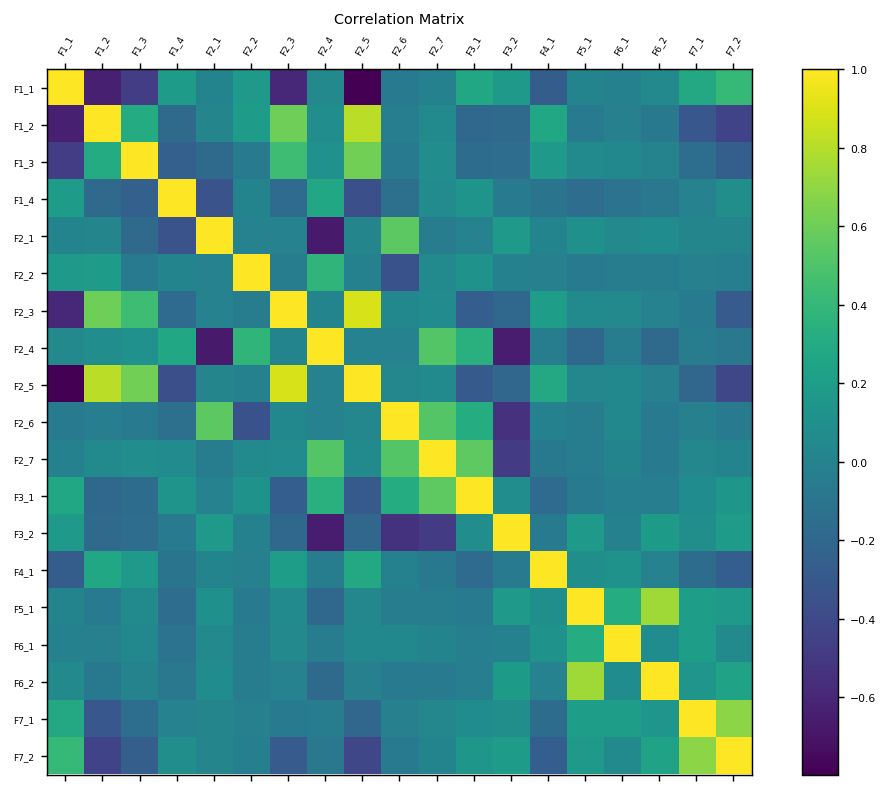

In [9]:
tt = pd.DataFrame(RR[1][:].numpy(), columns=ALL_ENTRIES)
plot_features_corr(tt[FEATURES])

In [269]:
# def plot_corr(self, features):
    
#     self.Features = _df_[features]
#     plot_features_corr(self.Features)

# def plot_order_book(self):
    
#     n_rows = 2
#     _, ax = plt.subplots(n_rows, figsize=(21, 14), dpi=300)
#     ax[0].set_title(f"{_df_['time'][0]} -- {_df_['time'][-1]}", fontsize=16)
#     ax[0].plot(_df_['a1_p'], color='r', label = 'Ask1 price', linewidth = 0.5)
#     ax[0].plot(_df_['a2_p'], color='orange', label = 'Ask2 price', linewidth = 0.5)
#     ax[0].plot(_df_['b1_p'], color='g', label = 'Bid1 price', linewidth = 0.5)
#     ax[0].plot(_df_['b2_p'], color='blue', label = 'Bid2 price', linewidth = 0.5)
#     ax[0].plot(_df_['WAP1'], color='pink', label = 'WAP1', linewidth = 0.5, linestyle='--')
#     ax[0].plot(_df_['WAP2'], color='purple', label = 'WAP2', linewidth = 0.5, linestyle='--', alpha = 0.8)
#     ax[0].get_xaxis().set_visible(False)
#     ax[0].legend()
#     ax[1].stackplot([i for i in range(600)], _df_['a1_v'], _df_['a2_v'], _df_['b1_v'], _df_['b2_v'], colors = ['r', 'orange', 'g', 'b'], alpha = 0.6, labels = ['Ask1 Volume', 'Ask2 Volume', 'Bid1 Volume', 'Bid2 Volume'])
#     ax[1].legend()
#     plt.tight_layout()

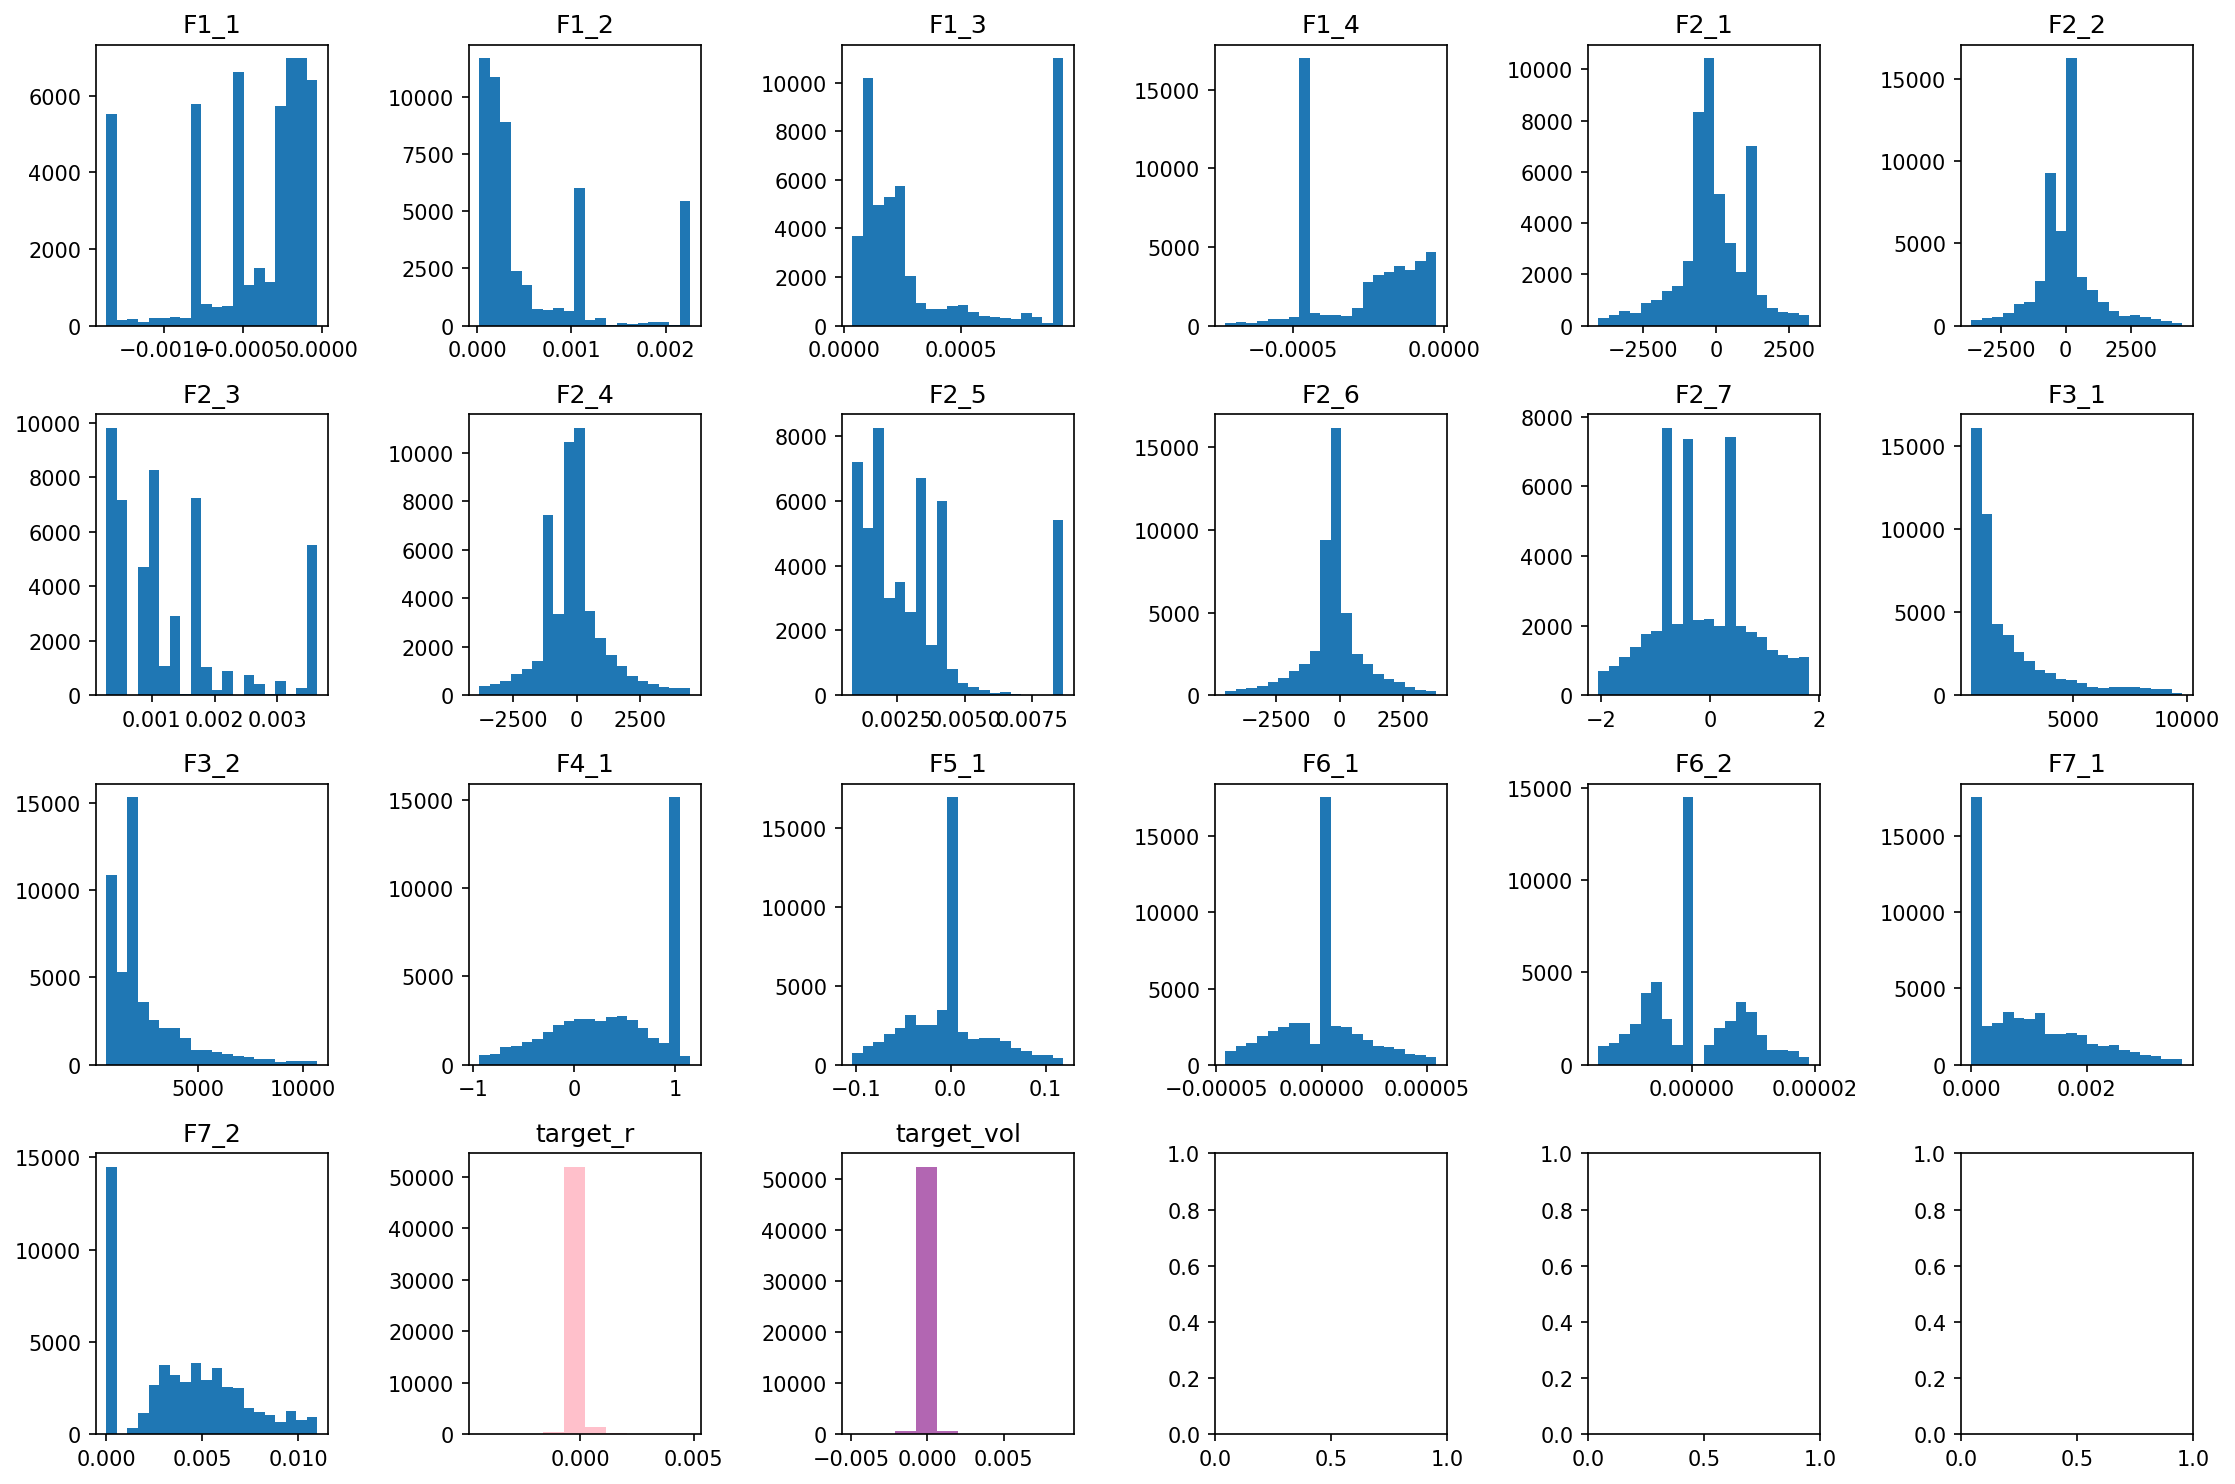

In [10]:
_, ax  = plt.subplots(nrows = 4, ncols=6, figsize =(15,  10), dpi = 150)
for i, feature in enumerate(FEATURES[:]):
    try:
        ttP = tt[feature]
        ttP = ttP.loc[(ttP.quantile(0.05) <= ttP) & (ttP <= ttP.quantile(0.95))]
        ax[i // 6][i % 6].hist(ttP, bins=20)
        ax[i // 6][i % 6].set_title(feature)
    except:
        print(feature)

ax[3][1].hist(tt['target_r'].dropna(), color='pink')
ax[3][1].set_title('target_r')
ax[3][2].hist(tt['target_vol'].dropna(), color='purple', alpha=0.6)
ax[3][2].set_title('target_vol')

plt.tight_layout()


In [24]:
quantile_transformer = QuantileTransformer(n_quantiles=300, random_state=233, output_distribution='normal')

In [22]:
RR[:,:,0].unsqueeze(2).shape
torch.cat([RR[:,:,0].unsqueeze(2), RR[:,:,1].unsqueeze(2)], 2).shape

torch.Size([2, 54003, 2])

In [40]:
quantile_transformer.fit_transform(RR[1,:,i].unsqueeze(1).numpy())

array([[ 1.68502975],
       [ 1.68502975],
       [ 1.68582919],
       ...,
       [-0.04331519],
       [-0.04331519],
       [-0.04331519]])

In [54]:
quantile_transformer = QuantileTransformer(n_quantiles=300, random_state=233, output_distribution='normal')
feature_tmp = []
for i in range(17):
    feature_tmp.append(quantile_transformer.fit_transform(RR[0,:,i].unsqueeze(1).numpy()))
for i in range(17, 25):
    feature_tmp.append(RR[1,:,i].unsqueeze(1).numpy())

normal_features = torch.tensor(feature_tmp)
normal_features = normal_features.transpose(0, 2)

for r in range(1, RR.shape[0]):
    feature_tmp = []
    for i in range(17):
        feature_tmp.append(quantile_transformer.fit_transform(RR[r,:,i].unsqueeze(1).numpy()))
    for i in range(17, 25):
        feature_tmp.append(RR[1,:,i].unsqueeze(1).numpy())

    normal_features_tmp = torch.tensor(feature_tmp)
    normal_features_tmp = normal_features_tmp.transpose(0, 2)
    normal_features = torch.cat([normal_features, normal_features_tmp], 0)
    

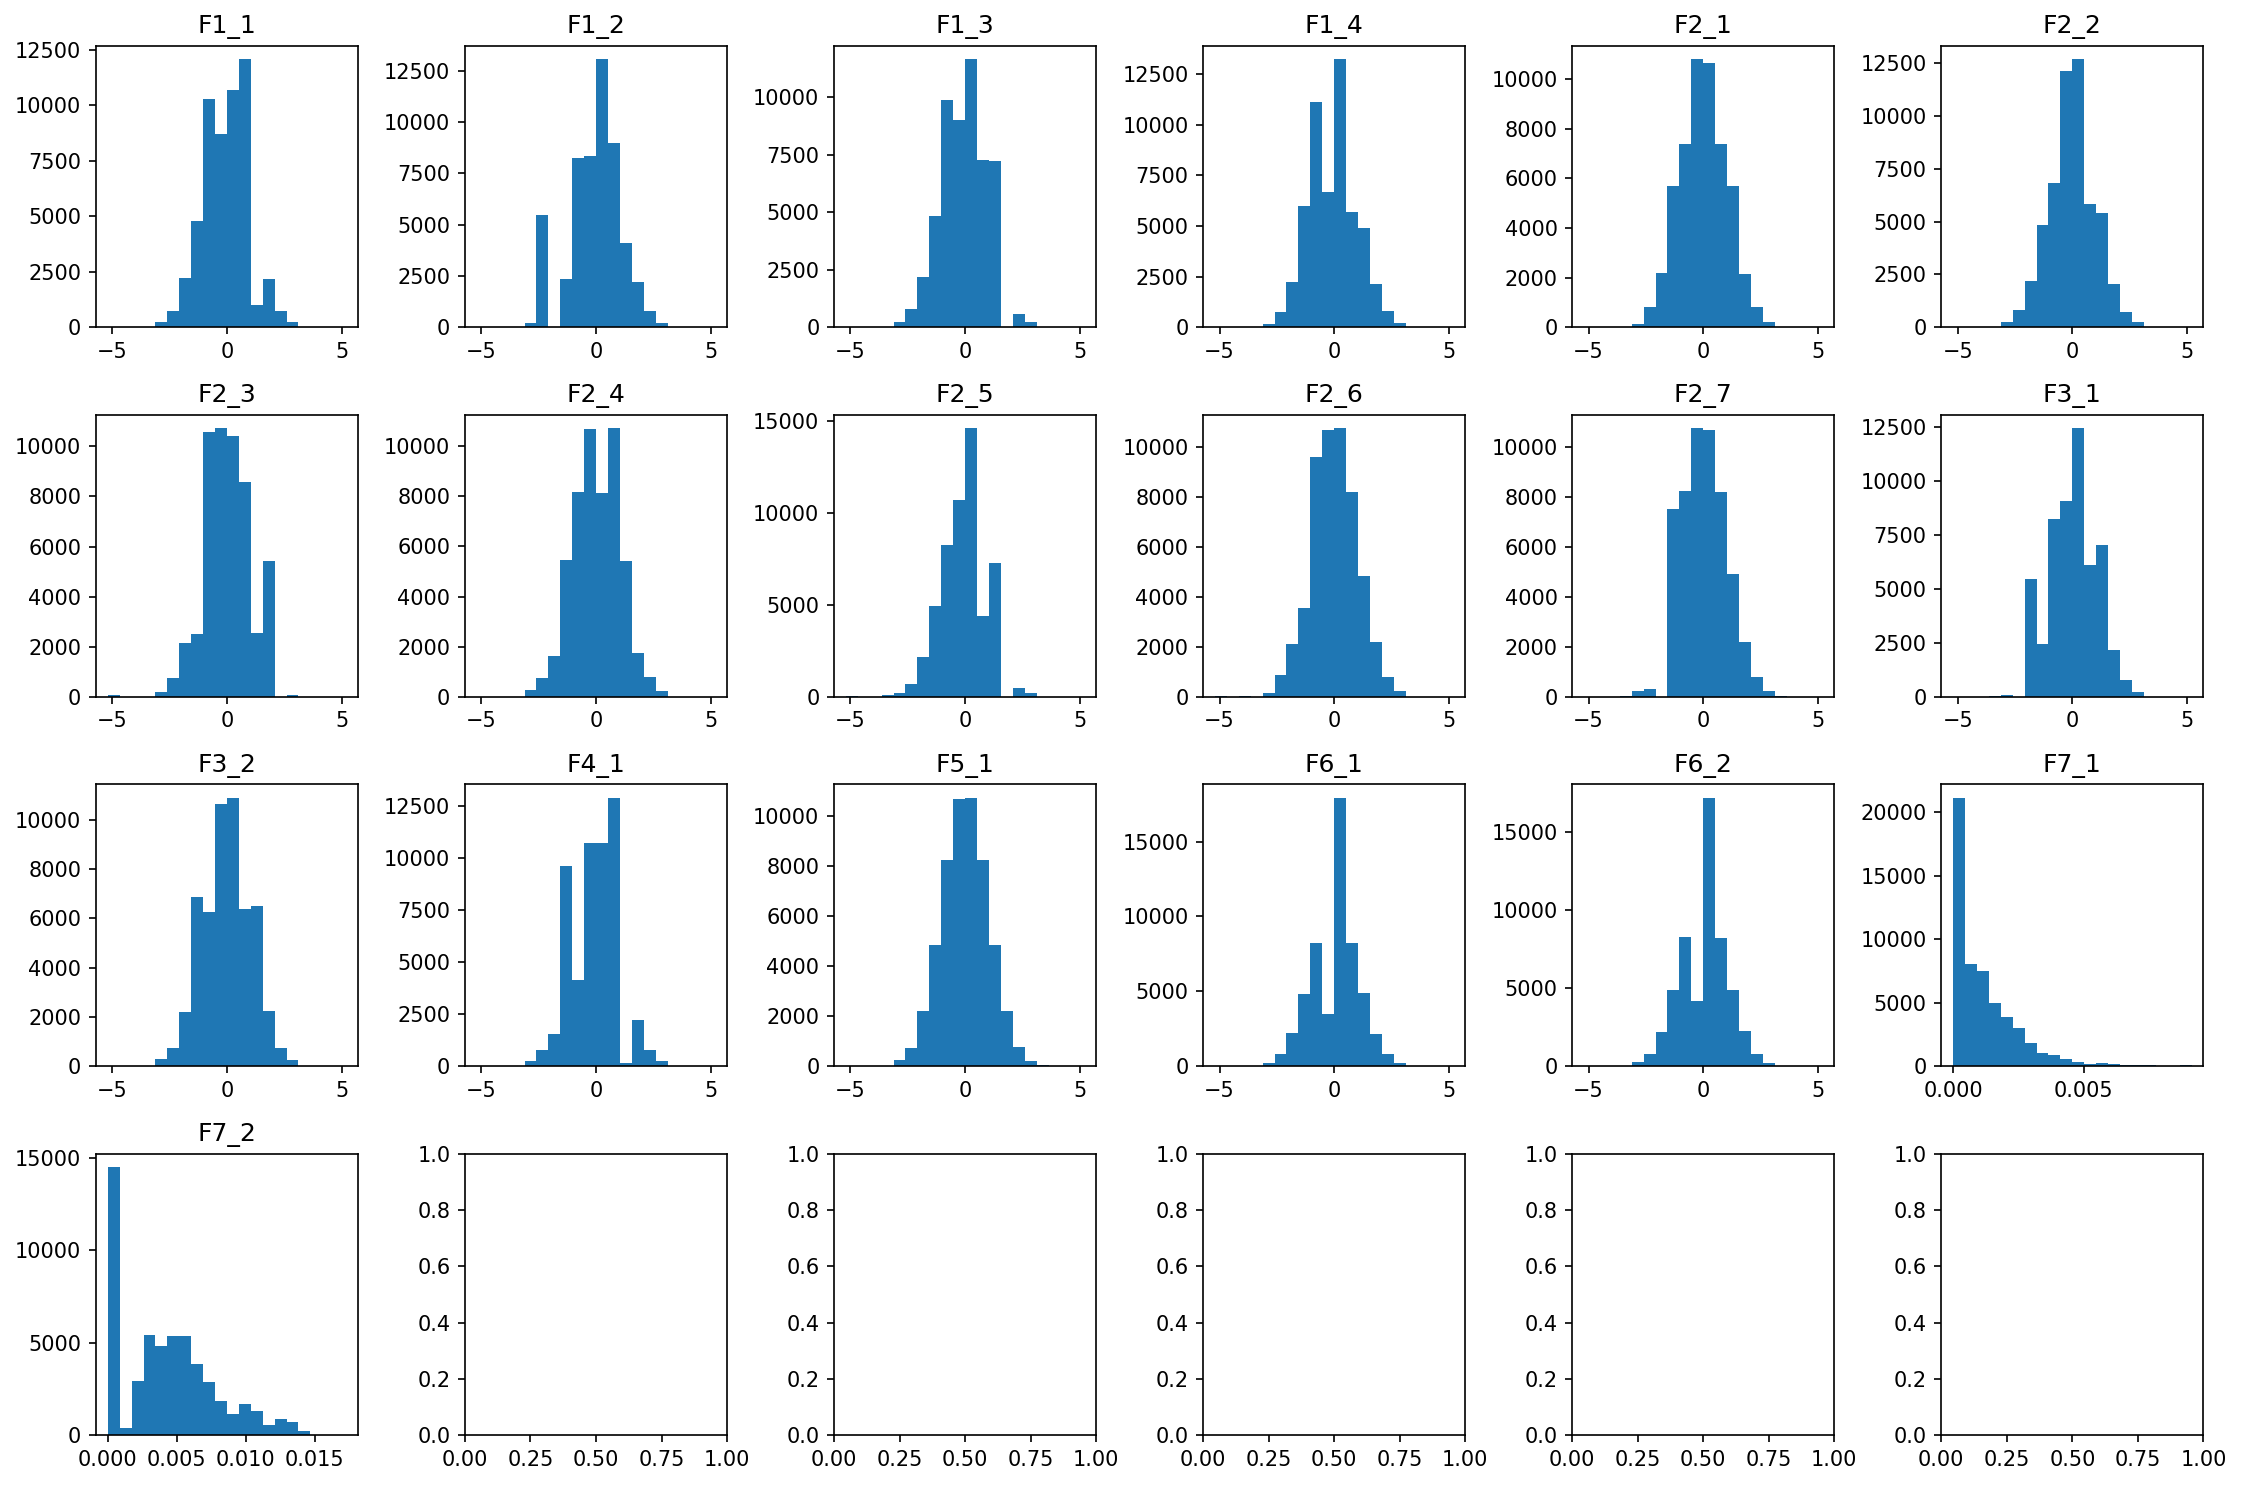

In [55]:
_, ax  = plt.subplots(nrows = 4, ncols=6, figsize =(15,  10), dpi = 150)
data = pd.DataFrame()
# quantile_transformer = QuantileTransformer(n_quantiles=300, random_state=233, output_distribution='normal')
for i in range(19):
    # _data = quantile_transformer.fit_transform(RR[1,:,i].unsqueeze(1).numpy())
    # data = quantile_transformer.fit_transform(data)
    # data = quantile_transformer.fit(RR[0,:,6][:4000]).transform(RR[0,:,6][4000:])
    ax[(i // 6)][i % 6].hist(normal_features[0,:,i], bins=20)
    ax[(i // 6)][i % 6].set_title(ALL_ENTRIES[i])

# ax[3][1].hist(RR['target_r'].dropna(), color='pink')
# ax[3][1].set_title('target_r')
# ax[3][2].hist(RR['target_vol'].dropna(), color='purple', alpha=0.6)
# ax[3][2].set_title('target_vol')

plt.tight_layout()

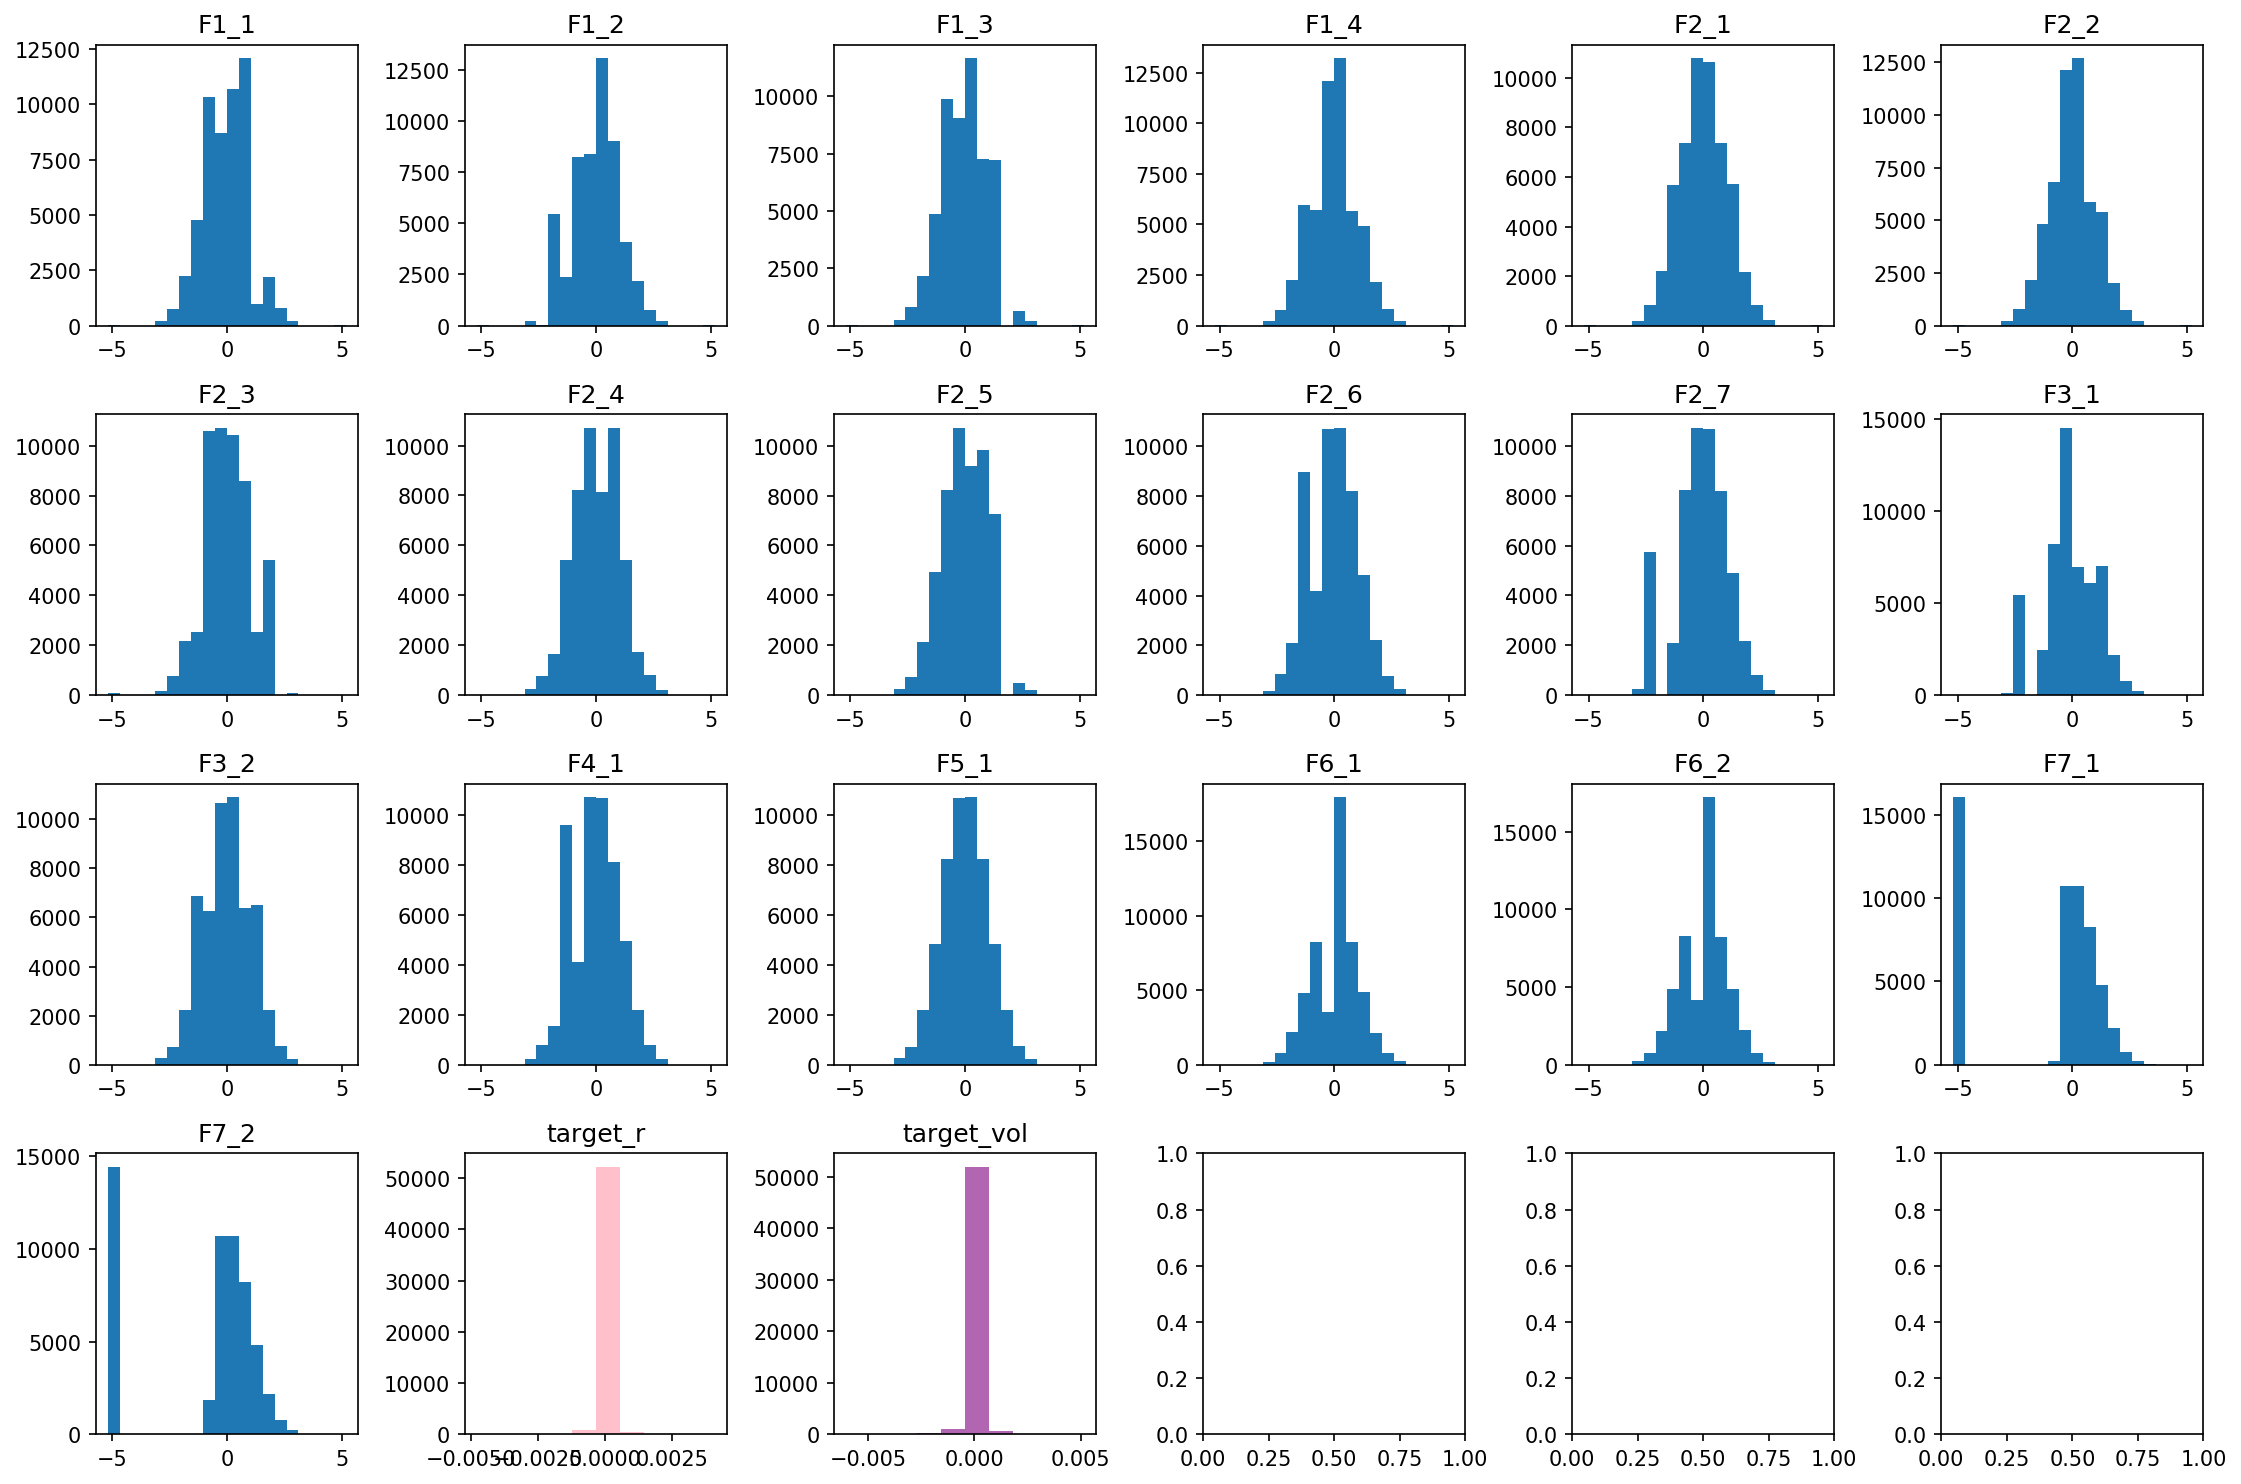

In [59]:
_, ax  = plt.subplots(nrows = 4, ncols=6, figsize =(15,  10), dpi = 150)
data = pd.DataFrame()
quantile_transformer = QuantileTransformer(n_quantiles=300, random_state=233, output_distribution='normal')
for i in range(19):
    _data = quantile_transformer.fit_transform(YY[0,:,i].unsqueeze(1).numpy())
    # data = quantile_transformer.fit_transform(data)
    # data = quantile_transformer.fit(RR[0,:,6][:4000]).transform(RR[0,:,6][4000:])
    ax[(i // 6)][i % 6].hist(_data, bins=20)
    ax[(i // 6)][i % 6].set_title(ALL_ENTRIES[i])

ax[3][1].hist(RR[0,:, -2], color='pink')
ax[3][1].set_title('target_r')
ax[3][2].hist(RR[0,:, -1], color='purple', alpha=0.6)
ax[3][2].set_title('target_vol')

plt.tight_layout()

### KNN

In [84]:
time_series_clusters = KMeans(n_clusters=CLUSTER_NUM, random_state=0).fit(YY[1,:,:17]) # time_series level cluster
# stock_id_clusters = KMeans(n_clusters=2, random_state=0).fit(YY[:,1,:17]) # stock_id level cluster
# random_clusters = KMeans(n_clusters=CLUSTER_NUM, random_state=0).fit(YY[1,:,:17]) # random level cluster

In [ ]:
joblib.dump(time_series_clusters, 'test.pkl')
model = joblib.load('test.pkl')
model.predict(YY[1,99,:17].unsqueeze(0))

In [94]:
# def add_time_series_cluster_features()
stock_slice = pd.DataFrame(YY[1, :, :].numpy(), columns=ALL_ENTRIES)
stock_slice

,F1_1,F1_2,F1_3,F1_4,F2_1,F2_2,F2_3,F2_4,F2_5,F2_6,...,F6_1,F6_2,F7_1,F7_2,WAP1,WAP2,r1,r2,target_r,target_vol
0,-1.125341,-0.728566,0.394915,0.117135,-0.337891,-1.490697,-0.803826,-0.399354,-0.180922,1.265193,...,1.122414,-1.665467,0.001435,0.011127,0.027588,0.322591,35.537027,35.531186,0.000000,0.000000
1,-1.125341,-0.728566,0.394915,0.117135,-0.337891,-1.490697,-0.803826,-0.399354,-0.180922,1.265193,...,1.122414,-1.665467,0.001435,0.011127,0.027408,0.321272,35.537027,35.531186,0.000000,0.000000
2,0.841895,-0.446551,-0.474101,0.483614,0.287135,0.950801,0.303554,1.282402,-0.375383,1.114033,...,1.122414,-1.665467,0.001478,0.011133,0.027051,0.319988,35.549706,35.547571,0.000357,0.000461
3,0.841895,-0.446551,-0.474101,0.483614,0.287135,0.950801,0.303554,1.282402,-0.375383,1.114033,...,1.132260,-1.212133,0.001478,0.010728,0.027051,0.318691,35.549706,35.547571,0.000000,0.000000
4,0.841895,-0.446551,-0.474101,0.483614,0.287135,0.950801,0.303554,1.282402,-0.375383,1.114033,...,1.132260,-1.212133,0.001478,0.010728,0.026328,0.317351,35.549706,35.547571,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53998,1.911079,-0.037947,-1.497594,0.095100,0.596371,1.339513,-0.853981,1.164683,-1.501885,0.494492,...,-0.814304,-1.014921,0.001086,0.003966,-0.008391,0.079006,35.772648,35.774852,0.000000,0.000000
53999,0.968261,0.449172,-1.497594,0.095100,0.596371,1.429707,-0.853611,1.405391,-0.969396,0.845049,...,-0.824807,-1.019318,0.001086,0.003966,-0.009212,0.078939,35.772027,35.768594,-0.000017,-0.000175
54000,0.968261,0.449172,-1.497594,0.095100,0.596371,1.429707,-0.853611,1.405391,-0.969396,0.845049,...,-0.824807,-1.019318,0.001086,0.003966,-0.009212,0.078867,35.772027,35.768594,0.000000,0.000000
54001,0.968261,0.449172,-1.497594,0.095100,0.596371,1.429707,-0.853611,1.405391,-0.969396,0.845049,...,-0.824807,-1.019318,0.001086,0.003966,-0.009212,0.078792,35.772027,35.768594,0.000000,0.000000


In [97]:
time_series_clusters = KMeans(n_clusters=CLUSTER_NUM, random_state=0).fit(YY[1,:,:17]) # time_series level cluster
stock_slice = pd.DataFrame(YY[1, :, :].numpy(), columns=ALL_ENTRIES) # tensor to DataFrame
stock_slice['Cluster_NO'] = time_series_clusters.labels_
groups = stock_slice.groupby('Cluster_NO')

,F1_1,F1_2,F1_3,F1_4,F2_1,F2_2,F2_3,F2_4,F2_5,F2_6,...,F6_2,F7_1,F7_2,WAP1,WAP2,r1,r2,target_r,target_vol,Cluster_NO
0,-1.125341,-0.728566,0.394915,0.117135,-0.337891,-1.490697,-0.803826,-0.399354,-0.180922,1.265193,...,-1.665467,0.001435,0.011127,0.027588,0.322591,35.537027,35.531186,0.000000,0.000000,5
1,-1.125341,-0.728566,0.394915,0.117135,-0.337891,-1.490697,-0.803826,-0.399354,-0.180922,1.265193,...,-1.665467,0.001435,0.011127,0.027408,0.321272,35.537027,35.531186,0.000000,0.000000,5
2,0.841895,-0.446551,-0.474101,0.483614,0.287135,0.950801,0.303554,1.282402,-0.375383,1.114033,...,-1.665467,0.001478,0.011133,0.027051,0.319988,35.549706,35.547571,0.000357,0.000461,0
3,0.841895,-0.446551,-0.474101,0.483614,0.287135,0.950801,0.303554,1.282402,-0.375383,1.114033,...,-1.212133,0.001478,0.010728,0.027051,0.318691,35.549706,35.547571,0.000000,0.000000,0
4,0.841895,-0.446551,-0.474101,0.483614,0.287135,0.950801,0.303554,1.282402,-0.375383,1.114033,...,-1.212133,0.001478,0.010728,0.026328,0.317351,35.549706,35.547571,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53998,1.911079,-0.037947,-1.497594,0.095100,0.596371,1.339513,-0.853981,1.164683,-1.501885,0.494492,...,-1.014921,0.001086,0.003966,-0.008391,0.079006,35.772648,35.774852,0.000000,0.000000,0
53999,0.968261,0.449172,-1.497594,0.095100,0.596371,1.429707,-0.853611,1.405391,-0.969396,0.845049,...,-1.019318,0.001086,0.003966,-0.009212,0.078939,35.772027,35.768594,-0.000017,-0.000175,0
54000,0.968261,0.449172,-1.497594,0.095100,0.596371,1.429707,-0.853611,1.405391,-0.969396,0.845049,...,-1.019318,0.001086,0.003966,-0.009212,0.078867,35.772027,35.768594,0.000000,0.000000,0
54001,0.968261,0.449172,-1.497594,0.095100,0.596371,1.429707,-0.853611,1.405391,-0.969396,0.845049,...,-1.019318,0.001086,0.003966,-0.009212,0.078792,35.772027,35.768594,0.000000,0.000000,0


In [160]:
def get_time_series_cluster_features(Stock_No, cluster_number = CLUSTER_NUM):
    
    time_series_clusters = KMeans(n_clusters=cluster_number, random_state=0).fit(YY[Stock_No,:,:17]) # time_series level cluster using first 17 features
    stock_slice = pd.DataFrame(YY[Stock_No,:,:].numpy(), columns=ALL_ENTRIES) # tensor to DataFrame
    stock_slice['Cluster_NO'] = time_series_clusters.labels_
    groups = stock_slice.groupby('Cluster_NO')

    Cluster_features_mean = pd.DataFrame(columns=FEATURES)
    Cluster_features_mean['Cluster_NO'] = [i for i in range(cluster_number)]
    Cluster_features_mean = Cluster_features_mean.set_index('Cluster_NO')

    Cluster_features_median = pd.DataFrame(columns=FEATURES)
    Cluster_features_median['Cluster_NO'] = [i for i in range(cluster_number)]
    Cluster_features_median = Cluster_features_median.set_index('Cluster_NO')

    Cluster_features_min = pd.DataFrame(columns=FEATURES)
    Cluster_features_min['Cluster_NO'] = [i for i in range(cluster_number)]
    Cluster_features_min = Cluster_features_min.set_index('Cluster_NO')

    Cluster_features_max = pd.DataFrame(columns=FEATURES)
    Cluster_features_max['Cluster_NO'] = [i for i in range(cluster_number)]
    Cluster_features_max = Cluster_features_max.set_index('Cluster_NO')

    for i in range(cluster_number):
        cluster_i = groups.get_group(i)
        for feature in FEATURES:
            Cluster_features_mean[feature].iloc[i] = cluster_i[feature].mean()
            Cluster_features_median[feature].iloc[i] = cluster_i[feature].median()
            Cluster_features_min[feature].iloc[i] = cluster_i[feature].min()
            Cluster_features_max[feature].iloc[i] = cluster_i[feature].max()


    Cluster_features =  {
        'mean': Cluster_features_mean,
        'median': Cluster_features_median,
        'min': Cluster_features_min,
        'max': Cluster_features_max,
    }

    for opr in ['mean', 'median', 'min', 'max']:
        print(f'[!] {opr}')
        # tqdm.pandas()
        for feature in tqdm(FEATURES):
            stock_slice[f'{feature}_{opr}'] = stock_slice['Cluster_NO'].apply(lambda x: Cluster_features[opr].iloc[x][feature])
        clear_output()
    return stock_slice



In [161]:
ttdf = get_time_series_cluster_features(1)
ttdf

In [191]:
ttdf

,F1_1,F1_2,F1_3,F1_4,F2_1,F2_2,F2_3,F2_4,F2_5,F2_6,...,F2_6_max,F2_7_max,F3_1_max,F3_2_max,F4_1_max,F5_1_max,F6_1_max,F6_2_max,F7_1_max,F7_2_max
0,0.870306,0.666308,-1.838082,-0.025732,1.917372,0.793992,1.107463,-1.011059,0.901153,-0.568410,...,-0.568410,-0.572186,0.324346,1.450291,0.443059,1.812221,-1.787636,-1.912049,0.001435,0.011127
1,-1.125341,-0.728566,0.394915,0.117135,-0.337891,-1.490697,-0.803826,-0.399354,-0.180922,1.265193,...,1.265193,0.696677,0.784042,0.336108,-0.397916,-1.189784,1.122414,-1.665467,0.001435,0.011127


In [195]:
import torch.nn.functional as F
source = torch.rand((5,10))
# now we expand to size (7, 11) by appending a row of 0s at pos 0 and pos 6, 
# and a column of 0s at pos 10
result = F.pad(input=source, pad=(0, 1, 1, 1), mode='constant', value=0)
print(result.shape)
print(source.shape)

torch.Size([7, 11])
torch.Size([5, 10])


In [196]:
RR.shape

torch.Size([2, 54003, 25])

In [207]:
pad = torch.zeros(RR.shape[0], RR.shape[1], 19*4*2)

In [208]:
RR = torch.cat([RR, pad], 2)
RR.shape

torch.Size([2, 54003, 177])

In [189]:
def get_stock_id_cluster_features(Time_No, cluster_number = CLUSTER_NUM):
    
    stock_id_clusters = KMeans(n_clusters=cluster_number, random_state=0).fit(YY[:,Time_No,:17]) # time_series level cluster using first 17 features
    
    time_slice = pd.DataFrame(YY[:,Time_No,:].numpy(), columns=ALL_ENTRIES) # tensor to DataFrame
    time_slice['Cluster_NO'] = stock_id_clusters.labels_
    groups = time_slice.groupby('Cluster_NO')

    Cluster_features_mean = pd.DataFrame(columns=FEATURES)
    Cluster_features_mean['Cluster_NO'] = [i for i in range(cluster_number)]
    Cluster_features_mean = Cluster_features_mean.set_index('Cluster_NO')

    Cluster_features_median = pd.DataFrame(columns=FEATURES)
    Cluster_features_median['Cluster_NO'] = [i for i in range(cluster_number)]
    Cluster_features_median = Cluster_features_median.set_index('Cluster_NO')

    Cluster_features_min = pd.DataFrame(columns=FEATURES)
    Cluster_features_min['Cluster_NO'] = [i for i in range(cluster_number)]
    Cluster_features_min = Cluster_features_min.set_index('Cluster_NO')

    Cluster_features_max = pd.DataFrame(columns=FEATURES)
    Cluster_features_max['Cluster_NO'] = [i for i in range(cluster_number)]
    Cluster_features_max = Cluster_features_max.set_index('Cluster_NO')

    for i in range(cluster_number):
        cluster_i = groups.get_group(i)
        for feature in FEATURES:
            Cluster_features_mean[feature].iloc[i] = cluster_i[feature].mean()
            Cluster_features_median[feature].iloc[i] = cluster_i[feature].median()
            Cluster_features_min[feature].iloc[i] = cluster_i[feature].min()
            Cluster_features_max[feature].iloc[i] = cluster_i[feature].max()


    Cluster_features =  {
        'mean': Cluster_features_mean,
        'median': Cluster_features_median,
        'min': Cluster_features_min,
        'max': Cluster_features_max,
    }

    for opr in ['mean', 'median', 'min', 'max']:
        print(f'[!] {opr}')
        # tqdm.pandas()
        for feature in tqdm(FEATURES):
            time_slice[f'{feature}_{opr}'] = time_slice['Cluster_NO'].apply(lambda x: Cluster_features[opr].iloc[x][feature])
        clear_output()
    return time_slice

In [190]:
ttdf = get_stock_id_cluster_features(1, 2)
ttdf

,F1_1,F1_2,F1_3,F1_4,F2_1,F2_2,F2_3,F2_4,F2_5,F2_6,...,F2_6_max,F2_7_max,F3_1_max,F3_2_max,F4_1_max,F5_1_max,F6_1_max,F6_2_max,F7_1_max,F7_2_max
0,0.870306,0.666308,-1.838082,-0.025732,1.917372,0.793992,1.107463,-1.011059,0.901153,-0.568410,...,-0.568410,-0.572186,0.324346,1.450291,0.443059,1.812221,-1.787636,-1.912049,0.001435,0.011127
1,-1.125341,-0.728566,0.394915,0.117135,-0.337891,-1.490697,-0.803826,-0.399354,-0.180922,1.265193,...,1.265193,0.696677,0.784042,0.336108,-0.397916,-1.189784,1.122414,-1.665467,0.001435,0.011127


In [148]:
stock_slice['Cluster_NO'].apply(lambda x: Cluster_features['max'].iloc[x]['F2_1'])

0        2.090539
1        2.090539
2        2.119805
3        2.119805
4        2.119805
           ...   
53998    2.119805
53999    2.119805
54000    2.119805
54001    2.119805
54002    2.119805
Name: Cluster_NO, Length: 54003, dtype: float64

In [127]:
cluster_i = groups.get_group(0)
cluster_i['F1_1'].mean()

1.2251026624556844

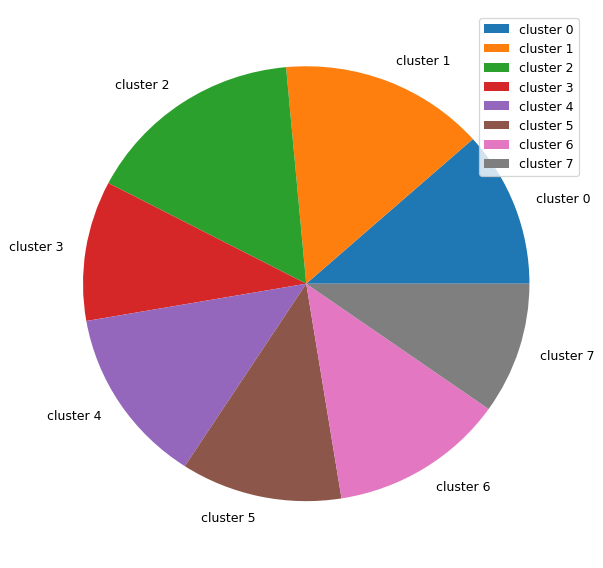

In [85]:
d = Counter(time_series_clusters.labels_)
d_s =sorted(d.items())
numbers = [x[1] for x in d_s]
labels = [f'cluster {x[0]}' for x in d_s]
plt.figure('Pie Chart Example', figsize=(8,8), facecolor='white', dpi=90)
plt.pie(numbers, labels=labels)
plt.legend()

prrr = pd.DataFrame(RR[0].numpy(), columns = ['target_r1', 'target_vol', 'WAP1', 'WAP2', 'r1', 'r2'] + FEATURES)
prrr['cluster'] = time_series_clusters.labels_
groups = prrr.groupby('cluster')

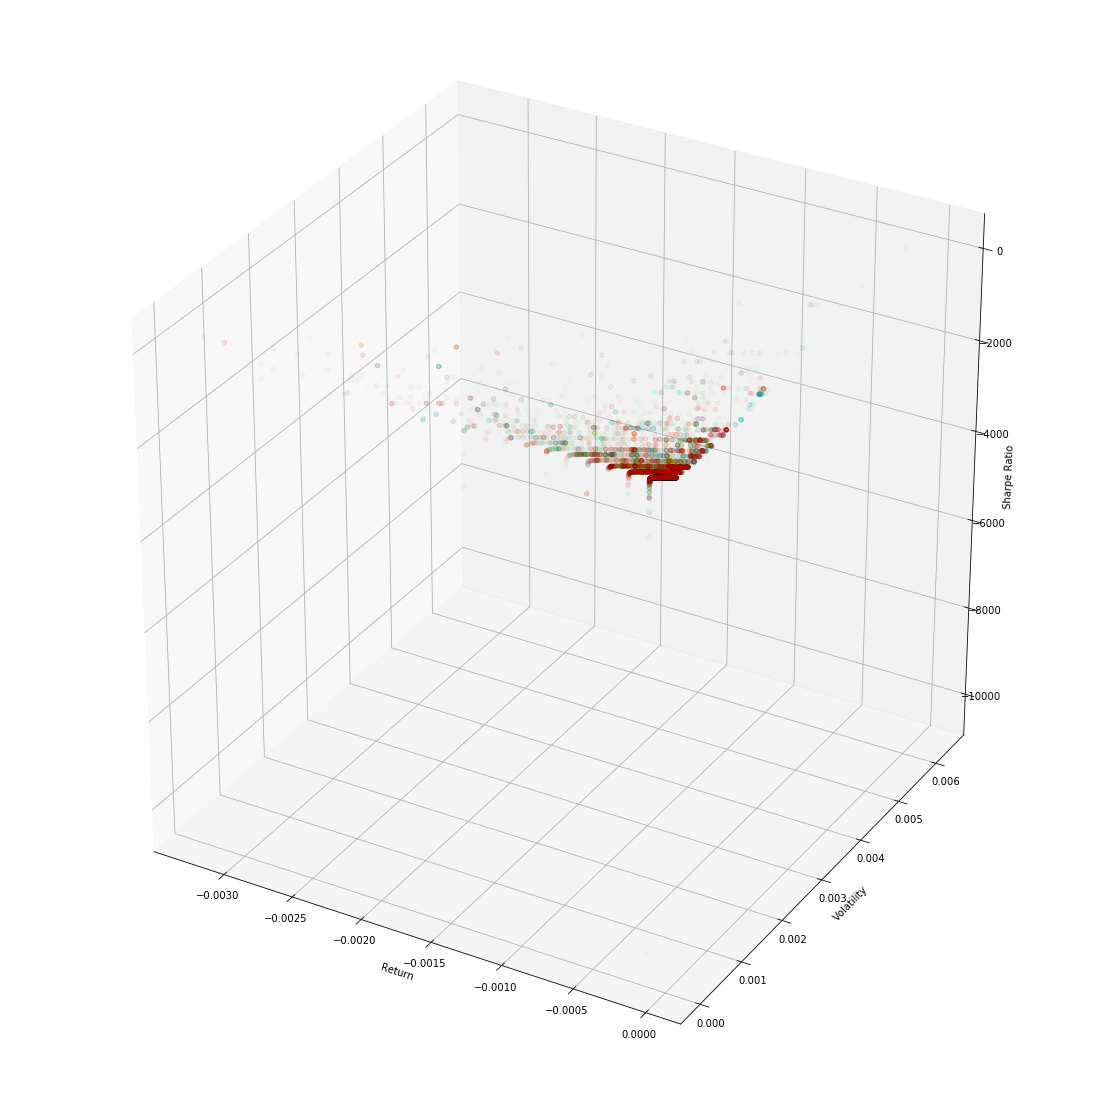

In [88]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 方式1：设置三维图形模式
fig = plt.figure(figsize=(15,15)) # 创建一个画布figure，然后在这个画布上加各种元素。
ax = Axes3D(fig) # 将画布作用于 Axes3D 对象上。
colors = ['lightcoral', 'red', 'darkorange', 'gold', 'olivedrab', 'cyan', 'springgreen', 'lightseagreen', 'darkviolet', 'royalblue', 'lime']
for i in range(CLUSTER_NUM):
    cluster = groups.get_group(i)
    xs = cluster['target_r1']
    ys = cluster['target_vol']
    zs = cluster['target_r1'] / cluster['target_vol']
    ax.scatter(xs,ys,zs,c=colors[i], alpha=0.01) # 画出(xs1,ys1,zs1)的散点图。

ax.set_xlabel('Return') # 画出坐标轴
ax.set_ylabel('Volatility')
ax.set_zlabel('Sharpe Ratio')

plt.show()